# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [167]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Einlesen mit h5py

In [168]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [169]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None

## Daten einlesen mit pyfact

In [170]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

In [171]:
#crab_events.head()

# Limits für theata^2 - Plot

In [172]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [173]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [174]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
# mask = (crab_events_pred.theta_deg_off_1 < limit_theta) | (crab_events_pred.theta_deg_off_2 < limit_theta) | (crab_events_pred.theta_deg_off_3 < limit_theta) | (crab_events_pred.theta_deg_off_4 < limit_theta) | (crab_events_pred.theta_deg_off_5 < limit_theta)
# crab_events_sel_all = crab_events_pred[mask]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [175]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


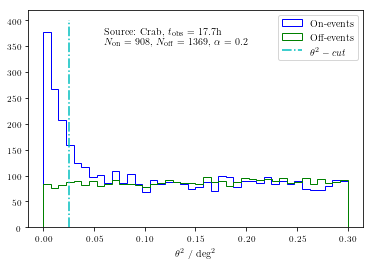

In [176]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))

print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

(40, 40)

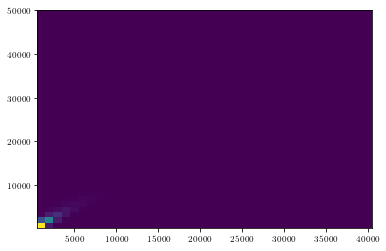

In [177]:
matrix, xedge, yedge, image = plt.hist2d(gammas_sel['gamma_energy_prediction'],
                                         gammas_sel['corsika_event_header_total_energy'], 
                                         bins=40, 
                                         normed='True')
np.shape(matrix)

Text(0, 0.5, 'gamma\\_true\\_energy')

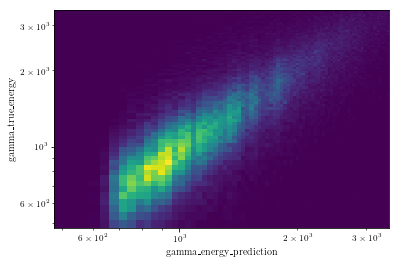

In [178]:
# definiere Grenzquantile für plot
up = np.quantile(gammas['corsika_event_header_total_energy'], 0.9)
low = np.quantile(gammas['corsika_event_header_total_energy'], 0.1)

plt.hist2d(gammas_sel['gamma_energy_prediction'],
                                         gammas_sel['corsika_event_header_total_energy'], 
                                         bins=80, 
                                         normed='True',
                                         range=[[low, up],[low, up]])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma\_energy\_prediction')
plt.ylabel('gamma\_true\_energy')

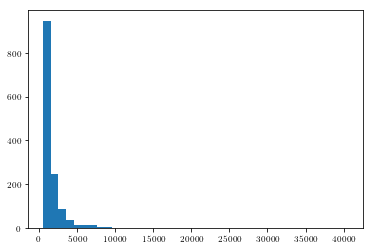

In [179]:
# Untergrund binnen
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge)

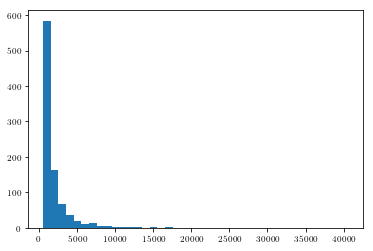

In [180]:
# Signal binnen
g, bins, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge)

In [181]:
# Penrose-Moore Pseudoinverse ausrechnen wegen Singularität
inv = np.linalg.pinv(matrix)

Unfolded: [-1.02775705e+09 -3.83360224e+08 -3.56370023e+08  3.78377434e+08
  2.36682718e+08  2.79836971e+08 -2.55016982e+09  2.73157604e+09
  3.61740595e+09  5.19007584e+09 -3.45704210e+10  1.80499904e+10
  4.22274314e+10 -5.53150299e+10  1.14877028e+10  7.72147735e+09
  2.78707235e+09  1.56631212e+10 -8.14276934e+09 -3.52657373e+10
 -7.08606131e+10  5.52907127e+10  8.08695145e+10  7.17192506e+10
  1.06391619e+10 -7.96045107e+10  3.57429037e+09 -7.96683447e-04
 -1.51280968e+11  1.45711674e+10 -8.44330474e+10  9.79748785e+10
 -2.47987658e+10 -4.79419183e-04  1.21749807e+10 -1.45085581e+11
  2.02772480e+11 -6.83012348e+09  5.05296647e-04  7.05923745e+10]
 shape (40,)


<ErrorbarContainer object of 3 artists>

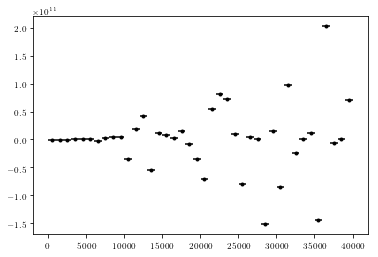

In [182]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.errorbar(xedge[:-1], inv.dot(ev), fmt='k.', xerr=(xedge[0] - xedge[1])/2)